In [1]:
import numpy as onp
import scipy as sp
import math
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial
import tensorflow_datasets as tfds
import gzip
from jax.config import config
config.update("jax_enable_x64", True)
import neural_tangents as nt
from neural_tangents import stax
from Utils.Utils_misc_functions import generate_datasets

## Data Loading and conversion

Below are functions I used to generate the data. train_data and test_data are dictionaries {'image':X, 'label': Y}. 
<br><br>
X are the images of size (32 x 32 x 3). Y represents one-hot encoded labels of dimension 10, where off entries are equal to -0.1 and on entries are equal to 0.9.The images were standardised with per channel mean and standard deviation

In [2]:
def standardise_images(images):
    '''
    standardise images across Channels
    '''
    mean = np.mean(images, axis=(1,2), keepdims=True)
    std = np.std(images, axis=(1,2), keepdims=True)
    standardised_images = (images - mean) / std
    return standardised_images

In [3]:
train_size = 250
test_size = 50
train_data, test_data = generate_datasets(train_size=train_size, test_size=test_size, type = 'cifar10', 
                                          flatten=False)

/dora/users/stfour/tuoz/stax_computing/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [17]:
print(train_data['image'].shape, train_data['label'].shape)

(250, 32, 32, 3) (250, 10)


In [18]:
print('The mean is {:.2f} and the variance is {:.2f}'.format(
    train_data['image'].mean(), train_data['image'].var()))

The mean is -0.00 and the variance is 1.00


In [6]:
train_data['label'][:3]

array([[-0.1,  0.9, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1,  0.9, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1,  0.9, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]],
      dtype=float32)

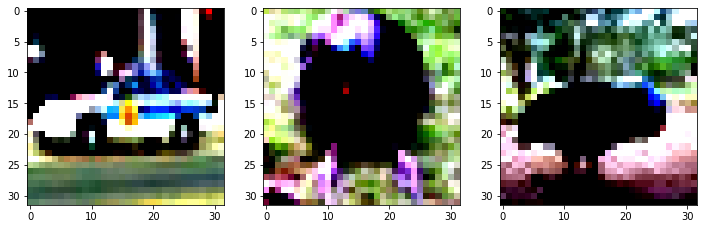

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
for i, ax in enumerate(axes):
    ax.imshow(train_data['image'][i])

## Modelling

In [8]:
key = random.PRNGKey(0)
def ConvolutionalNetwork(depth, W_std=1.0, b_std=0.0):
    layers = []
    for _ in range(depth):
        layers += [stax.Conv(1, (3, 3), W_std = W_std, b_std = b_std, padding='SAME'), stax.Relu()]
    layers += [stax.Flatten(), stax.Dense(10, W_std, b_std)]    
    return stax.serial(*layers)

In [15]:
depth = 5
init_fn, apply_fn, kernel_fn = ConvolutionalNetwork(depth = depth)
batched_kernel_fn = nt.batch(kernel_fn, batch_size=10, store_on_device= False)

## Calculating the Marginal Log Likelihood of a GP

The marginal log-likelihood of a G.P with 0 mean and covariance $K_y$ according to Rasmussen is:<br>
<br>
$log(p(Y|x) = -\frac{1}{2}y^TK_y^{-1}y - \frac{1}{2}log(|K_y|) - \frac{n}{2}log(2\pi)$ <br><br>
$-log(p(Y|x) = \frac{1}{2}y^TK_y^{-1}y + \frac{1}{2}log(|K_y|) + \frac{n}{2}log(2\pi)$ <br>

Where <br>
* $Y$ is a flattened $Cn \times 1$ shaped vector of the outputs of the NN
* The matrix $K_y = K \otimes I_{10}$, where K is the original covariance matrix obtained by default from the kernel function of neural tangents. I used nt.utils.utils.make_2d to turn this into a 2d matrix. 
<br><br>

$K_y = LL^T$, where $L$ is lower triangular
<br>
$log(|K_y|) = 2\sum_{i = 1}^{n}log L_{ii}$



<!-- $\begin{bmatrix} 
k_{11} & k_{12} & \dots & k_{1n}\\ 
k_{21} & k_{22} & \dots & k_{2n} \\ 
\dots &\\
k_{n1} & k_{n2} & \dots & k_{nn} 
\end{bmatrix}$


Where:
$K_{ij}$ is a 10 by 10 matrix 

* $K_y$ is be a $Cn \times Cn$ covariance matrix, where C is the number of classes and n is the number of training or test points. For training points, I take this to be $K(X_{train}, X_{train})$ and for test points, I use $K(X_{test}, X_{test})$
* $Y$ is a flattened $Cn \times 1$ shaped vector of the outputs of the NN<br> -->

In [20]:
def negative_mll(X, Y):
    '''
    X: training inputs (images). Shape (n x 32 x 32 x 3)
    Y: training outputs. Shape (n x 10)
    '''
    # First calculate K(x_train, x_train)
    k_dd = batched_kernel_fn(X, get = 'nngp')
    
    # Shape (n, 1)
    y = Y.flatten()[:, np.newaxis] 
    # Shape (1,n)
    y_t = y.T

    # Shape (n x n x 10 x 10)
    k_dd_big = np.tensordot(k_dd, np.eye(10), axes = 0)
    # Shape (10n x 10n)
    k_dd_big = nt.utils.utils.make_2d(k_dd_big)

    # Cholesky factorisation
    l = sp.linalg.cho_factor(k_dd_big, lower= True)
    k_inv_y = sp.linalg.cho_solve(l, y)

    # First term
    likelihood_term = 0.5*(y_t@k_inv_y)
    # Middle term
    determinant_term = np.sum(np.log(np.diag(l[0])))
    # last term
    constant_term = 0.5*y.shape[0]*np.log(2*np.pi)
    
    # Full mll
    negative_log_likelihood = likelihood_term + determinant_term + constant_term
    
    return negative_log_likelihood/y.shape[0]

In [25]:
nll_list = []
for n in [100, 200, 300, 500, 1000]:
    print(n)
    train_data, _ = generate_datasets(train_size=n, test_size=10, type = 'cifar10', flatten=False)
    X, Y = train_data['image'], train_data['label']
    nll = negative_mll(X, Y)
    nll_list.append(nll[0])

100
200
300
500
1000


In [26]:
nll_list

[DeviceArray([6.86632167], dtype=float64),
 DeviceArray([8.41041578], dtype=float64),
 DeviceArray([8.99545243], dtype=float64),
 DeviceArray([10.46552396], dtype=float64),
 DeviceArray([12.40615475], dtype=float64)]

Text(0, 0.5, 'Negative Marginal log likelihood')

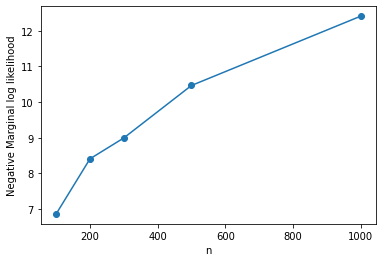

In [31]:
plt.plot([100, 200, 300, 500, 1000], nll_list, 'o-')
plt.xlabel('n')
plt.ylabel('Negative Marginal log likelihood')